# 1. Load essential modules

In [1003]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from  keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K
from keras import layers
from keras.initializers import Zeros
from keras.callbacks import EarlyStopping
from keras.models import load_model
import tensorflow as tf 

# Set random seed
np.random.seed(0)

In [1004]:
# Set figure size for all matplotlib figures
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

### Load Data

In [1005]:
df = pd.read_csv('Foreign_Exchange_Rates.csv')
df.head()

,DATE,SINGAPORE - SINGAPORE DOLLAR/US$,CHINA - YUAN/US$
0,2000-01-03,1.6563,8.2798
1,2000-01-04,1.6535,8.2799
2,2000-01-05,1.656,8.2798
3,2000-01-06,1.6655,8.2797
4,2000-01-07,1.6625,8.2794


# 2.Data Description and Visualization

### Rename the column names

In [1006]:
df = df.rename(columns={"SINGAPORE - SINGAPORE DOLLAR/US$": "SGD_USD", "CHINA - YUAN/US$": "CNY_USD"})
df.head()

,DATE,SGD_USD,CNY_USD
0,2000-01-03,1.6563,8.2798
1,2000-01-04,1.6535,8.2799
2,2000-01-05,1.656,8.2798
3,2000-01-06,1.6655,8.2797
4,2000-01-07,1.6625,8.2794


### Check for missing values

In [1007]:
df.describe()

,DATE,SGD_USD,CNY_USD
count,5217,5217,5217
unique,5217,2927,2711
top,2000-01-03,ND,8.2765
freq,1,198,208


### Handle missing values
As mentioned in the document and as evident here, for holidays, there are some entries as “ND” which means "No Data". 
So I replaced them with “NaN” values by np.nan and then forward fill. 

In [1008]:
df = df.replace('ND', np.nan)
df = df.ffill()
df.isna().sum() # Using df.isna().sum() no “NaN” value is found.

DATE       0
SGD_USD    0
CNY_USD    0
dtype: int64

In [1009]:
df.describe()

,DATE,SGD_USD,CNY_USD
count,5217,5217,5217
unique,5217,2926,2710
top,2000-01-03,1.3591,8.2765
freq,1,9,214


In [1010]:
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dtypes

DATE        object
SGD_USD    float64
CNY_USD    float64
dtype: object

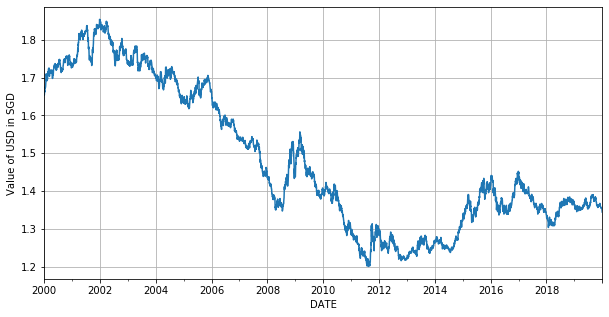

In [1081]:
plt.rcParams["figure.figsize"] = fig_size
df['SGD_USD'].plot()
plt.ylabel('Value of USD in SGD')
plt.grid()

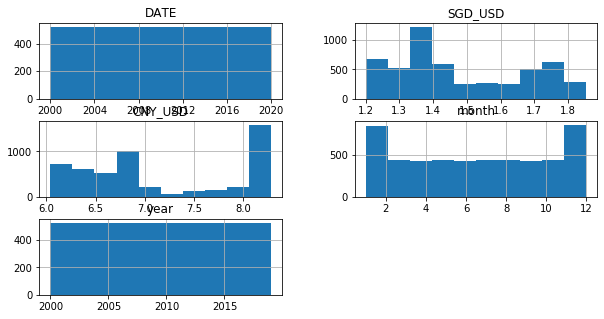

In [1012]:
# Add another few columns such as YYYY-MM, MM, YYYY and use it in charts.
df['DATE'] = pd.to_datetime(df['DATE'])
df['month'] = df['DATE'].dt.month
df['year'] = df['DATE'].dt.year
df['month_year'] = df['DATE'].dt.to_period('M')
df.hist()
plt.show()

In [1013]:
df.dtypes

DATE          datetime64[ns]
SGD_USD              float64
CNY_USD              float64
month                  int64
year                   int64
month_year         period[M]
dtype: object

Convert object values to numeric by type conversion

In [1014]:
df['DATE'] = pd.to_datetime(df['DATE']) 
df.set_index('DATE', inplace=True)
df.index = pd.to_datetime(df.index)

# 3. Stationarity analysis

## Evaluate Stationarity

In [1015]:
# ADF test on raw data (without transformation)
# The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend
df_test = adfuller(df['SGD_USD'], autolag='AIC')
result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                   -1.072435
p-value                           0.725938
#Lags Used                        8.000000
Number of Observations Used    5208.000000
Critical Value (1%)              -3.431606
Critical Value (5%)              -2.862095
Critical Value (10%)             -2.567065
dtype: float64


##### Conclusions:

1. Absolute value of t-statistic is lesser than any critical value.
2. p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. p-value is very close to 1 than 0.
3. Therefore, we fail to reject the null hypothesis. In other words, this series has unit root meaing it is non-stationarity. In the following section, a few possible methods of inducing stationarity are evaluated.

## Add Stationairty

### a. Difference between data and moving average

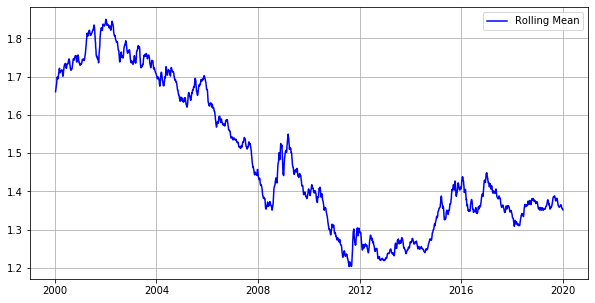

In [1016]:
# Calculate and plot the rolling mean
# Consider only SGD_USD data
rolling_mean = pd.Series.rolling(df['SGD_USD'],window=7,center=False).mean()
plt.rcParams["figure.figsize"] = fig_size
rmean = plt.plot(rolling_mean, color='blue', label='Rolling Mean')
plt.legend(loc='best')
plt.grid()
plt.show()

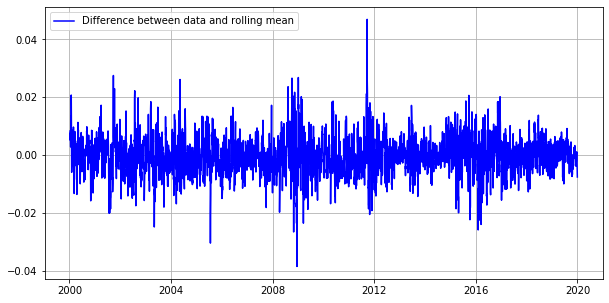

In [1017]:
# Subtract rolling mean from the data and plot
rolling_mean_diff=df['SGD_USD']-rolling_mean
#plt.rcParams["figure.figsize"] = fig_size
plt.plot(rolling_mean_diff, color='blue',label='Difference between data and rolling mean')
plt.legend(loc='best')
plt.grid()
plt.show()
rolling_mean_diff.dropna(inplace=True)

In [1018]:
# ADF on transformed data
df_rmean_diff = adfuller(rolling_mean_diff, autolag='AIC')
result_rmean_diff = pd.Series(df_rmean_diff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_rmean_diff[4].items():
    result_rmean_diff['Critical Value (%s)'%key] = value
print (result_rmean_diff)

Test Statistic                  -20.033174
p-value                           0.000000
#Lags Used                        8.000000
Number of Observations Used    5202.000000
Critical Value (1%)              -3.431608
Critical Value (5%)              -2.862096
Critical Value (10%)             -2.567066
dtype: float64


##### Conclusions:

The p-value is zero. This is an acceptable level of stationarity.

There are a lot other ways to do this like Moving average of log(data), Exponentially Weighted Moving Average of Log, First order differencing

Lets explore the few other ways.

### b. Moving average of log(data)

Take the log of the data, calculate the rolling mean of the logarithm and subtract it from the logarithmic transform

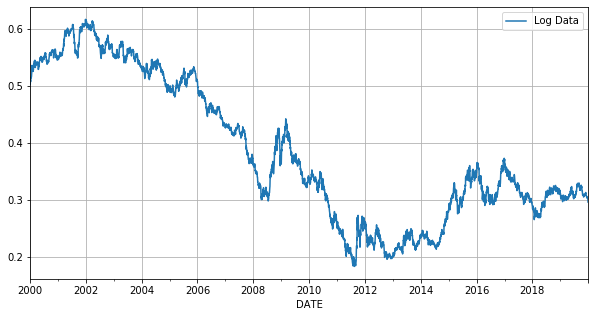

In [1019]:
# Calculate and plot logarithm of the data
sgd_data_log=np.log(df['SGD_USD'])
plt.rcParams["figure.figsize"] = fig_size
sgd_data_log.plot(label='Log Data')
plt.legend(loc='best')
plt.grid()
plt.show()

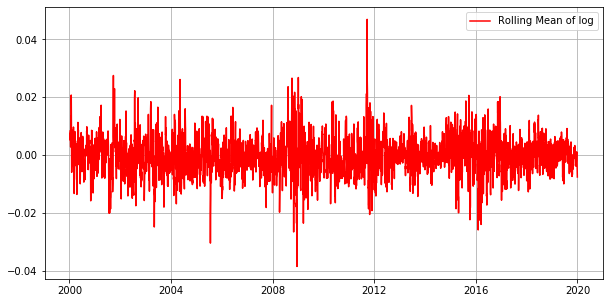

In [1020]:
# Calculate and plot differnece between rolling mean of logarithm and the logarithm
log_rolling_mean=pd.Series.rolling(sgd_data_log,window=7,center=False).mean()
plt.rcParams["figure.figsize"] = fig_size
log_rolmean_diff=sgd_data_log-log_rolling_mean
log_rmean_diff= plt.plot(rolling_mean_diff, color='red', label='Rolling Mean of log')
plt.legend(loc='best')
plt.grid()
plt.show()
log_rolmean_diff.dropna(inplace=True)

In [1021]:
# Perform ADF on the transformation
df_test_log = adfuller(log_rolmean_diff, autolag='AIC')
result_log = pd.Series(df_test_log[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_log[4].items():
    result_log['Critical Value (%s)'%key] = value
print (result_log)

Test Statistic                  -20.159644
p-value                           0.000000
#Lags Used                        8.000000
Number of Observations Used    5202.000000
Critical Value (1%)              -3.431608
Critical Value (5%)              -2.862096
Critical Value (10%)             -2.567066
dtype: float64


### c. First order differencing

This transformation is done by subtracting consecutive points of the series.

No handles with labels found to put in legend.


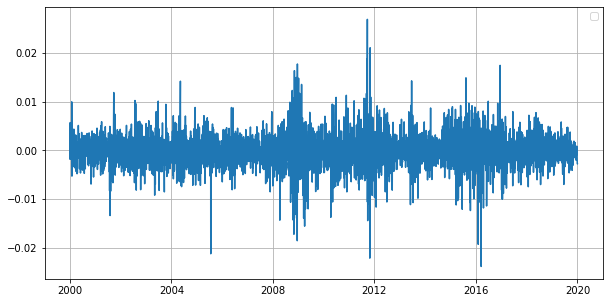

In [1022]:
# Calculate and plot the first order differnece

sgd_log_diff = sgd_data_log - sgd_data_log.shift()
sgd_log_diff.dropna(inplace=True)
plt.rcParams["figure.figsize"] = fig_size
plt.plot(sgd_log_diff)
plt.legend('Log Data')
plt.legend(loc='best')
plt.grid()
plt.show()

In [1023]:
# Perform ADF test

df_test_logdiff = adfuller(sgd_log_diff, autolag='AIC')
result_logdiff = pd.Series(df_test_logdiff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_logdiff[4].items():
    result_logdiff['Critical Value (%s)'%key] = value
print (result_logdiff)

Test Statistic                  -23.904682
p-value                           0.000000
#Lags Used                        7.000000
Number of Observations Used    5208.000000
Critical Value (1%)              -3.431606
Critical Value (5%)              -2.862095
Critical Value (10%)             -2.567065
dtype: float64


### d. Exponentially Weighted Moving Average of Log

Take the exponentially weighted moving average

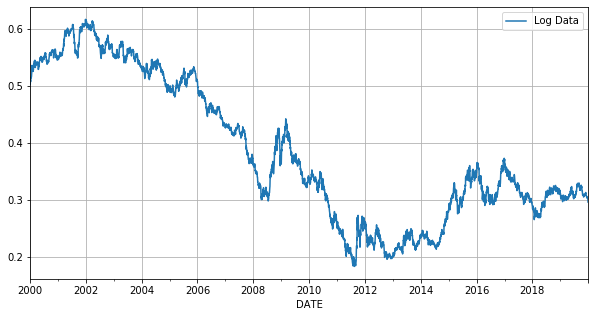

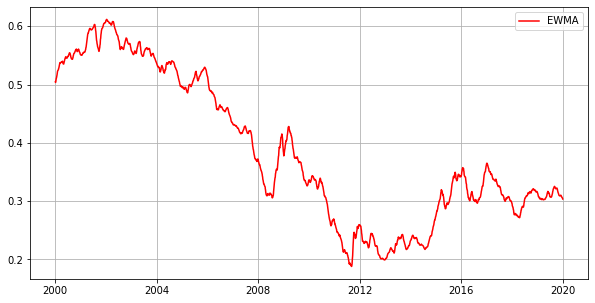

In [1024]:
ewma_data=pd.Series.ewm(sgd_data_log,halflife=7,min_periods=0,adjust=True,ignore_na=False).mean()
plt.rcParams["figure.figsize"] = fig_size
sgd_data_log.plot(label='Log Data')
plt.legend(loc='best')
plt.grid()
plt.show()

# Calculate EWMA and plot
plt.plot(ewma_data, color='red',label='EWMA')
plt.legend()
plt.legend(loc='best')
plt.grid()
plt.show()

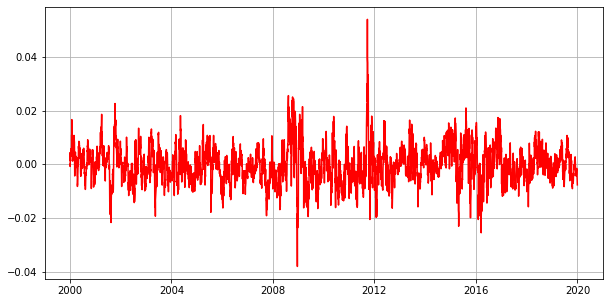

In [1025]:
# Calculate and plot difference

ewma_diff=sgd_data_log-ewma_data
plt.rcParams["figure.figsize"] = fig_size
plt.plot(ewma_diff, color='red')
plt.grid()
plt.show()

In [1026]:
# Perform ADF test

df_test_ewma = adfuller(ewma_diff, autolag='AIC')
result_ewma = pd.Series(df_test_ewma[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_ewma[4].items():
    result_ewma['Critical Value (%s)'%key] = value
print (result_ewma)

Test Statistic                -1.383715e+01
p-value                        7.406977e-26
#Lags Used                     8.000000e+00
Number of Observations Used    5.208000e+03
Critical Value (1%)           -3.431606e+00
Critical Value (5%)           -2.862095e+00
Critical Value (10%)          -2.567065e+00
dtype: float64


### e. Decomposition (Trend+Seasonal+Residual)

3 Systematic components and 1 non-systematic components

1. Level: The average value in the series.
2. Trend: The increasing or decreasing value in the series.
3. Seasonality: The repeating short-term cycle in the series.
4. Noise: The random variation in the series.

All series have a level and noise. The trend and seasonality components are optional.

I will use seasonal_decompose to decompose the dataset into differnet components.
Seasonal_decompose tells us how our dataset looks in terms of trend, seasonal and residual

In [1027]:
#df['DATE'] = pd.to_datetime(df['DATE']) 
#df.set_index('DATE', inplace=True)
df.index = pd.to_datetime(df.index)
# Decompose logarithm of the series
sgd_data_log=np.log(df['SGD_USD'])
decomposition = seasonal_decompose(sgd_data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

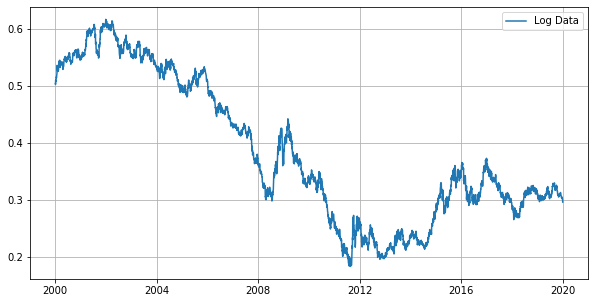

In [1028]:
# Plot logarithm of series
plt.rcParams["figure.figsize"] = fig_size
plt.plot(sgd_data_log,label='Log Data')
plt.legend()
plt.grid()
plt.show()

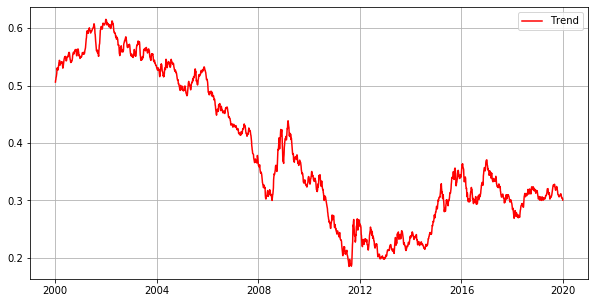

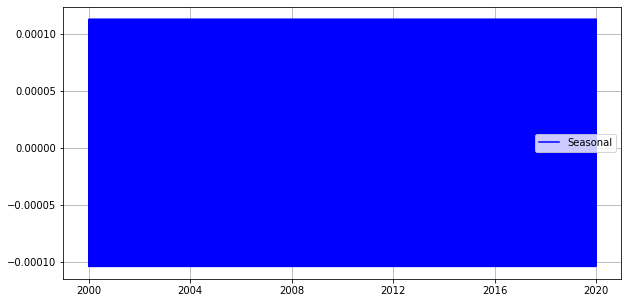

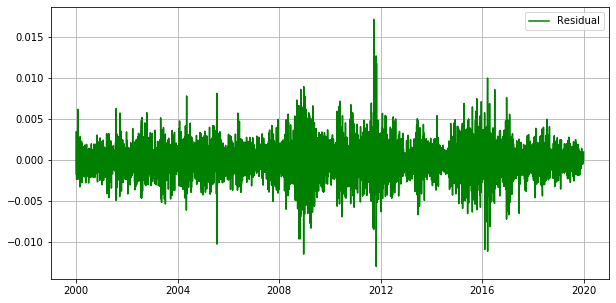

In [1029]:
# Plot trend, seasonality and residual
plt.plot(trend,color='red',label='Trend')
plt.legend()
plt.grid()
plt.show()

plt.plot(seasonal,color='Blue',label='Seasonal')
plt.legend()
plt.grid()
plt.show()

plt.plot(resid,color='green',label='Residual')
plt.legend()
plt.grid()
plt.show()

In [1030]:
# Perform ADT
resid.dropna(inplace=True)

df_test_resid = adfuller(resid, autolag='AIC')
result_resid = pd.Series(df_test_resid[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_resid[4].items():
    result_resid['Critical Value (%s)'%key] = value
print (result_resid)

Test Statistic                  -22.046971
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5179.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


## Comparison

In [1031]:
compare=pd.DataFrame({'Test Statistic':[result_rmean_diff.iloc[0],result_log.iloc[0],result_ewma.iloc[0],result_logdiff.iloc[0],result_resid.iloc[0]],
                      'p-value':[result_rmean_diff.iloc[1],result_log.iloc[1],result_ewma.iloc[1],result_logdiff.iloc[1],result_resid.iloc[1]]})
Methods=['Data Rolling mean','Log Data Rolling Mean','Log EWMA','First Order Differencing','Seasonal Decomposition']
compare['Methods']=Methods
compare=compare.set_index('Methods')
compare

,Test Statistic,p-value
Methods,,
Data Rolling mean,-20.033174,0.000000e+00
Log Data Rolling Mean,-20.159644,0.000000e+00
Log EWMA,-13.837150,7.406977e-26
First Order Differencing,-23.904682,0.000000e+00
Seasonal Decomposition,-22.046971,0.000000e+00


## Suggestion to use which method

- We can see, all except LOG EWMA gave best smoothing of data as seen from p-value. 
- So, to choose the best method out of these 4, I would also consider t-value. 
- The larger the absolute value of the t-value, the smaller the p-value, and the greater the evidence against the null hypothesis.
-  Hence, First order differencing is selected to transform the series.

## Determine time lags

After making the dataset stationary, we move on to the 2nd step of the process: determining the p, d, q for the ARIMA model. This can be done by looking at ACF and PACF plots

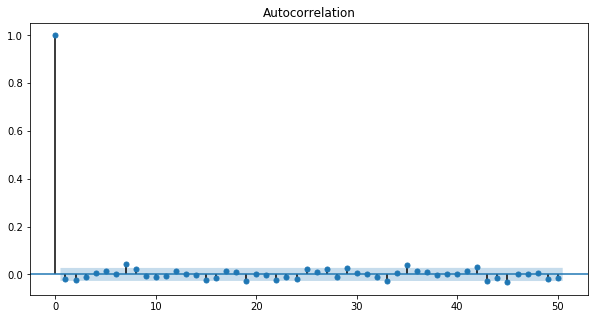

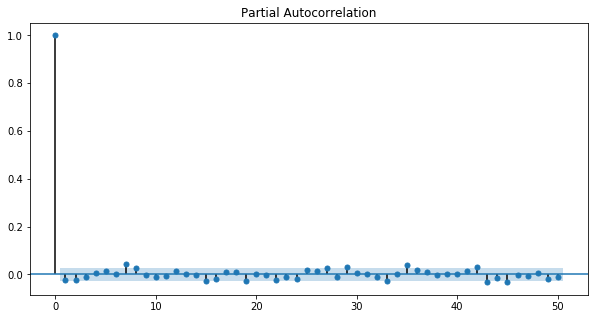

In [1032]:
plot_acf(sgd_log_diff,lags=50)
plt.show()

plot_pacf(sgd_log_diff,lags=50)
plt.show()

- In this case, both ACF and PACF cut-off after the first lag. 
- As you can see in ACF plot, a large spike is seen in lag 1
- Likewise, in the PACF plot, a large spike is seen in lage 1
- There is no rigid indication of the orders p and q as required by ARIMA. 
- The closest contenders are ARIMA(1,1,1) and ARIMA(1,1,0).

Let’s see how ARIMA looks with the following values:
- p = 1 as 1 significant lag in ACF
- q = 1 as 1 significant lag in PACF
- d = 0

# ARIMA Model
Since, our ACF and PACF do not indicate an appreciable correlation with lagged values, we will limit our prediction to only one data point after the last data point.

### ARIMA 1-day Ahead Forecast

In [1033]:
data1 = sgd_data_log.values
train_size = int(np.floor(len(data1)*0.9))

train = list(data1[0:train_size])
test = list(data1[train_size:])


train_list = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(np.array(train),order=(1,1,0))
    fit = model.fit()
    forecast = float(fit.forecast()[0])
    predictions.append(forecast)
    train.append(float(test[t]))

C:\Users\meetn\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\meetn\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\meetn\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\meetn\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\meetn\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

Mean squared error: 0.000009


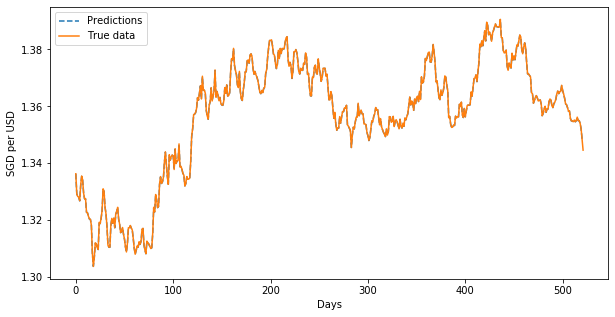

In [1034]:
plt.plot(np.exp(predictions)[1:],'--',label='Predictions')
plt.plot(np.exp(test),label='True data')
plt.ylabel('SGD per USD')
plt.xlabel('Days')
plt.legend()
plt.plot()

print ('Mean squared error: {0:3f}'.format(MSE(np.exp(test),np.exp(predictions))))

In [1035]:
## Value of currency tomorrow will be:

#Tomorrow's value
train = list(data1)

train_list = [x for x in train]
predictions = []

model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
forecast = float(fit.forecast()[0])

tomorrow_value = np.exp(forecast)

# Today's value

sgd_data_log = sgd_data_log[:-1]
data1 = sgd_data_log.values
train = list(data1)

train_list = [x for x in train]
predictions = []

model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
forecast = float(fit.forecast()[0])
today_value = np.exp(forecast)

print ("Today's actual value is {0:3f} and model predicted {1:3f}.".format(df.values[-1][0],today_value))
print ("Model predicts value will be {0:3f} tomorrow.".format(tomorrow_value))

Today's actual value is 1.344600 and model predicted 1.348324.
Model predicts value will be 1.344623 tomorrow.


### ARIMA Multiple Day Ahead Forecast

Mean squared error: 0.001969


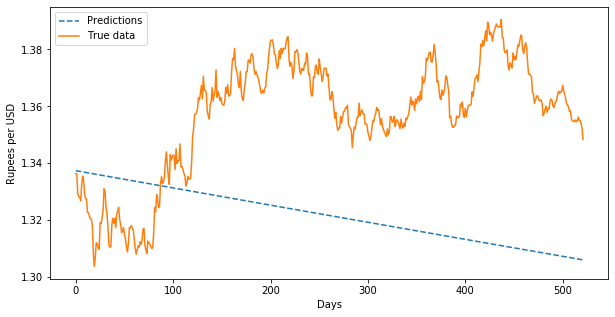

In [1036]:
data1 = sgd_data_log.values
train_size = int(np.floor(len(data1)*0.9))

train = list(data1[0:train_size])
test = list(data1[train_size:])


model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
predictions = fit.forecast(len(test))[0]
plt.plot(np.exp(predictions),'--',label='Predictions')
plt.plot(np.exp(test),label='True data')
#plt.plot(np.exp(full_predictions),label='Full prediction')
plt.ylabel('Rupees per USD')
plt.xlabel('Days')
plt.legend()
plt.plot()

print ('Mean squared error: {0:3f}'.format(MSE(np.exp(test),np.exp(predictions))))

The model continues the upward decreasing trend. Since, ARIMA is a linear model, forecasting using ARIMA for anywhere more than 1 day fails. 

Models to be used:
1. An ARIMA model
2. A feedforward neural network (FNN)
3. Long term short memory (LSTM) recurrent neural network (RNN) 

## Rolling window of 1 week

In [1037]:
'''df_rm = pd.Series.rolling(df['SGD_USD'],window=7,center=False).mean()
df_rm.dropna(inplace=True)
df_train = df_rm.loc[:"2018"]
df_test = df_rm.loc["2019":]
print(df_train.tail(), df_test.head())
train = list(df_train)
test = list(df_test)'''

'df_rm = pd.Series.rolling(df[\'SGD_USD\'],window=7,center=False).mean()\ndf_rm.dropna(inplace=True)\ndf_train = df_rm.loc[:"2018"]\ndf_test = df_rm.loc["2019":]\nprint(df_train.tail(), df_test.head())\ntrain = list(df_train)\ntest = list(df_test)'

In [1038]:
df_train = df.loc[:"2018"]
df_test = df.loc["2019":]
rm_train = pd.Series.rolling(df_train['SGD_USD'],window=7,center=False).mean()
#rm_diff_train=df_train['SGD_USD']-rm_train
rm_train.dropna(inplace=True)

rm_test = pd.Series.rolling(df_test['SGD_USD'],window=7,center=False).mean()
#rm_diff_test=df_test['SGD_USD']-rm_test
rm_test.dropna(inplace=True)

train = list(rm_train)
test = list(rm_test)
#print(train, test)

## 1. ARIMA

In [1039]:
train_list = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(np.array(train),order=(1,1,0))
    fit = model.fit()
    forecast = float(fit.forecast()[0])
    predictions.append(forecast)
    train.append(float(test[t]))

C:\Users\meetn\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Mean squared error: 0.000012
Root Mean squared error: 0.003515
Mean absolute percentage error: 0.000449


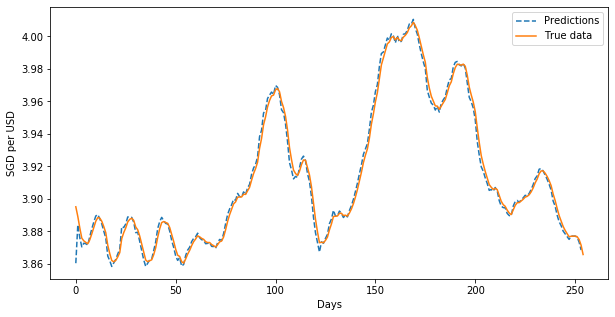

In [1040]:
plt.plot(np.exp(predictions)[1:],'--',label='Predictions')
plt.plot(np.exp(test),label='True data')
plt.ylabel('SGD per USD')
plt.xlabel('Days')
plt.legend()
plt.plot()
mse_arima = MSE(np.exp(test),np.exp(predictions))
rmse_arima = np.sqrt(mse_arima)
mape_arima = MAPE(np.exp(test),np.exp(predictions))
print('Mean squared error: {0:3f}'.format(mse_arima))
print('Root Mean squared error: {0:3f}'.format(rmse_arima))
print('Mean absolute percentage error: {0:3f}'.format(mape_arima))

In [1041]:
df_train.values[-1]

array([1.3623, 6.8755, 12, 2018, Period('2018-12', 'M')], dtype=object)

In [1042]:
## Value of currency tomorrow will be:

# Today's value

rm_train = rm_train[:-1]
train = list(rm_train)

model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
today_value = float(fit.forecast()[0])

#Tomorrow's value
train = list(rm_train)

model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
tomorrow_value = float(fit.forecast()[0])

# df_train.values[-1][0] - Stands for the last row in train
# df_test.values[1][0] - Stands for first row in test

print ("Today's actual value is {0:3f} and model predicted {1:3f}.".format(df_train.values[-1][0],today_value))
print ("Tomorrow's actual value is {0:3f} and model predicts value will be {1:3f}.".format(df_test.values[1][0], tomorrow_value))

Today's actual value is 1.362300 and model predicted 1.371062.
Tomorrow's actual value is 1.365200 and model predicts value will be 1.371062.


## 2. XGBoost

In [1043]:
df_train = df.loc[:"2018"]
df_test = df.loc["2019":]
rm_train = pd.Series.rolling(df_train['SGD_USD'],window=7,center=False).mean()
rm_train.dropna(inplace=True)

rm_test = pd.Series.rolling(df_test['SGD_USD'],window=7,center=False).mean()
rm_test.dropna(inplace=True)

rm_train = pd.DataFrame(rm_train)
rm_train['SGD_USD_Target'] = rm_train['SGD_USD'].shift(-1)
rm_train.dropna(inplace=True)
rm_test = pd.DataFrame(rm_test)
rm_test['SGD_USD_Target'] = rm_test['SGD_USD'].shift(-1)
rm_test.dropna(inplace=True)

train = rm_train.values
test = rm_test.values
#print(train)
X_train,y_train = train[:, :-1], train[:, -1]
X_test,y_test = test[:, :-1], test[:, -1]

In [1044]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)
testpred = model.predict(X_test)

Mean squared error: 0.000020
Root Mean squared error: 0.004478
Mean absolute percentage error: 0.000889


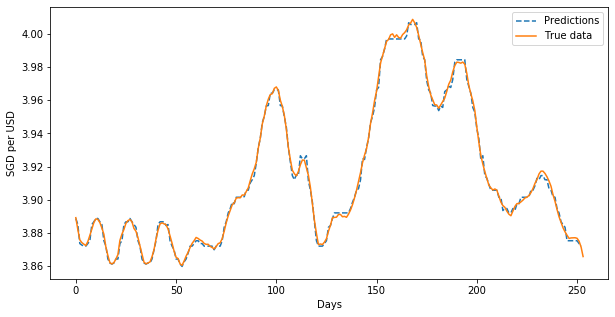

In [1045]:
plt.plot(np.exp(testpred)[1:],'--',label='Predictions')
plt.plot(np.exp(y_test),label='True data')
plt.ylabel('SGD per USD')
plt.xlabel('Days')
plt.legend()
plt.plot()
mse_xgboost = MSE(np.exp(y_test),np.exp(testpred))
rmse_xgboost = np.sqrt(mse_xgboost)
mape_xgboost = MAPE(np.exp(y_test),np.exp(testpred))
print('Mean squared error: {0:3f}'.format(mse_xgboost))
print('Root Mean squared error: {0:3f}'.format(rmse_xgboost))
print('Mean absolute percentage error: {0:3f}'.format(mape_xgboost))

## 3. Feedforward Neural Network

In [1047]:
df_train = df.loc[:"2018"]
df_test = df.loc["2019":]
rm_train = pd.Series.rolling(df_train['SGD_USD'],window=7,center=False).mean()
rm_train.dropna(inplace=True)

rm_test = pd.Series.rolling(df_test['SGD_USD'],window=7,center=False).mean()
rm_test.dropna(inplace=True)

rm_train = pd.DataFrame(rm_train)
rm_train['SGD_USD_Target'] = rm_train['SGD_USD'].shift(-1)
rm_train.dropna(inplace=True)
rm_test = pd.DataFrame(rm_test)
rm_test['SGD_USD_Target'] = rm_test['SGD_USD'].shift(-1)
rm_test.dropna(inplace=True)

train = rm_train.values
test = rm_test.values
#print(train)
X_train,y_train = train[:, :-1], train[:, -1]
X_test,y_test = test[:, :-1], test[:, -1]

#### 3a) 1 Hidden Layers with 1 neuron and relu activation function

In [1048]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
4949/4949 [==============================] - 0s 44us/step - loss: 3.9282e-04
Epoch 2/20
4949/4949 [==============================] - 0s 34us/step - loss: 1.7639e-05
Epoch 3/20
4949/4949 [==============================] - 0s 33us/step - loss: 1.1751e-05
Epoch 4/20
4949/4949 [==============================] - 0s 40us/step - loss: 7.4667e-06
Epoch 5/20
4949/4949 [==============================] - 0s 37us/step - loss: 4.9313e-06
Epoch 6/20
4949/4949 [==============================] - 0s 36us/step - loss: 3.7248e-06
Epoch 7/20
4949/4949 [==============================] - 0s 35us/step - loss: 3.2936e-06
Epoch 8/20
4949/4949 [==============================] - 0s 34us/step - loss: 3.1542e-06
Epoch 9/20
4949/4949 [==============================] - 0s 34us/step - loss: 3.1200e-06
Epoch 10/20
4949/4949 [==============================] - 0s 35us/step - loss: 3.1920e-06
Epoch 11/20
4949/4949 [==============================] - 0s 35us/step - loss: 3.1938e-06
Epoch 12/20
4949/4949 [=======

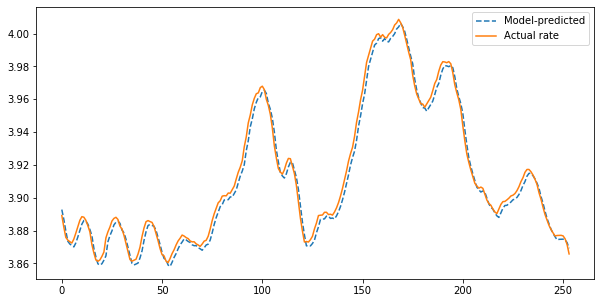

Mean squared error: 0.000021
Root Mean squared error: 0.004553
Mean absolute percentage error: 0.000974


In [1049]:
y_pred  =  model.predict(X_test)
plt.plot(np.exp(y_pred),'--',label='Model-predicted')
plt.plot(np.exp(y_test),label='Actual rate')
plt.legend()
plt.show()
mse_fnn = MSE(np.exp(y_test), np.exp(y_pred))
rmse_fnn = np.sqrt(mse_fnn)
mape_fnn = MAPE(np.exp(y_test), np.exp(y_pred))
print('Mean squared error: {0:3f}'.format(mse_fnn))
print('Root Mean squared error: {0:3f}'.format(rmse_fnn))
print('Mean absolute percentage error: {0:3f}'.format(mape_fnn))

#### 3b) 2 Hidden Layers with 50 neurons each and ReLU activation function

In [1050]:
df_train = df.loc[:"2018"]
df_test = df.loc["2019":]
rm_train = pd.Series.rolling(df_train['SGD_USD'],window=7,center=False).mean()
rm_train.dropna(inplace=True)

rm_test = pd.Series.rolling(df_test['SGD_USD'],window=7,center=False).mean()
rm_test.dropna(inplace=True)

rm_train = pd.DataFrame(rm_train)
rm_train['SGD_USD_Target'] = rm_train['SGD_USD'].shift(-1)
rm_train.dropna(inplace=True)
rm_test = pd.DataFrame(rm_test)
rm_test['SGD_USD_Target'] = rm_test['SGD_USD'].shift(-1)
rm_test.dropna(inplace=True)

train = rm_train.values
test = rm_test.values
#print(train)
X_train,y_train = train[:, :-1], train[:, -1]
X_test,y_test = test[:, :-1], test[:, -1]

In [1051]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
4949/4949 [==============================] - 0s 58us/step - loss: 9.7255e-04
Epoch 2/20
4949/4949 [==============================] - 0s 41us/step - loss: 3.9308e-06
Epoch 3/20
4949/4949 [==============================] - 0s 44us/step - loss: 4.2268e-06
Epoch 4/20
4949/4949 [==============================] - 0s 47us/step - loss: 4.8533e-06
Epoch 5/20
4949/4949 [==============================] - 0s 42us/step - loss: 6.6843e-06
Epoch 6/20
4949/4949 [==============================] - 0s 42us/step - loss: 6.0707e-06
Epoch 7/20
4949/4949 [==============================] - 0s 42us/step - loss: 1.0062e-05
Epoch 8/20
4949/4949 [==============================] - 0s 42us/step - loss: 1.4171e-05
Epoch 9/20
4949/4949 [==============================] - 0s 43us/step - loss: 1.2028e-05
Epoch 10/20
4949/4949 [==============================] - 0s 46us/step - loss: 2.7074e-05
Epoch 11/20
4949/4949 [==============================] - 0s 45us/step - loss: 2.0228e-05
Epoch 12/20
4949/4949 [=======

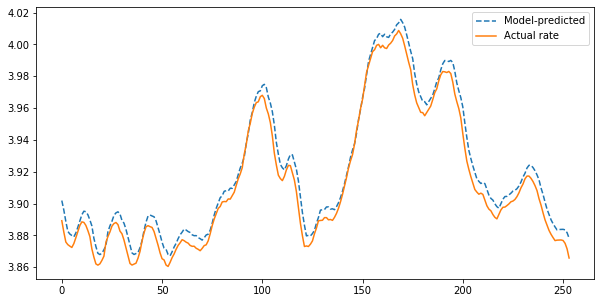

Mean squared error: 0.000063
Root Mean squared error: 0.007939
Mean absolute percentage error: 0.001781


In [1052]:
y_pred2  =  model.predict(X_test)
plt.plot(np.exp(y_pred2),'--',label='Model-predicted')
plt.plot(np.exp(y_test),label='Actual rate')
plt.legend()
plt.show()
mse_fnn2 = MSE(np.exp(y_test), np.exp(y_pred2))
rmse_fnn2 = np.sqrt(mse_fnn2)
mape_fnn2 = MAPE(np.exp(y_test), np.exp(y_pred2))
print('Mean squared error: {0:3f}'.format(mse_fnn2))
print('Root Mean squared error: {0:3f}'.format(rmse_fnn2))
print('Mean absolute percentage error: {0:3f}'.format(mape_fnn2))

#### 3c) 4 Hidden Layers with 100 neurons each and ReLU activation function

In [1053]:
df_train = df.loc[:"2018"]
df_test = df.loc["2019":]
rm_train = pd.Series.rolling(df_train['SGD_USD'],window=7,center=False).mean()
rm_train.dropna(inplace=True)

rm_test = pd.Series.rolling(df_test['SGD_USD'],window=7,center=False).mean()
rm_test.dropna(inplace=True)

rm_train = pd.DataFrame(rm_train)
rm_train['SGD_USD_Target'] = rm_train['SGD_USD'].shift(-1)
rm_train.dropna(inplace=True)
rm_test = pd.DataFrame(rm_test)
rm_test['SGD_USD_Target'] = rm_test['SGD_USD'].shift(-1)
rm_test.dropna(inplace=True)

train = rm_train.values
test = rm_test.values
#print(train)
X_train,y_train = train[:, :-1], train[:, -1]
X_test,y_test = test[:, :-1], test[:, -1]

In [1054]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
4949/4949 [==============================] - 0s 70us/step - loss: 0.0323
Epoch 2/20
4949/4949 [==============================] - 0s 49us/step - loss: 5.0368e-05
Epoch 3/20
4949/4949 [==============================] - 0s 49us/step - loss: 1.6592e-05
Epoch 4/20
4949/4949 [==============================] - 0s 51us/step - loss: 5.5400e-06
Epoch 5/20
4949/4949 [==============================] - 0s 51us/step - loss: 3.8577e-06
Epoch 6/20
4949/4949 [==============================] - 0s 50us/step - loss: 4.1575e-06
Epoch 7/20
4949/4949 [==============================] - 0s 50us/step - loss: 4.0242e-06
Epoch 8/20
4949/4949 [==============================] - 0s 52us/step - loss: 4.4202e-06
Epoch 9/20
4949/4949 [==============================] - 0s 50us/step - loss: 5.0050e-06
Epoch 10/20
4949/4949 [==============================] - 0s 50us/step - loss: 5.5990e-06
Epoch 11/20
4949/4949 [==============================] - 0s 59us/step - loss: 6.4456e-06
Epoch 12/20
4949/4949 [===========

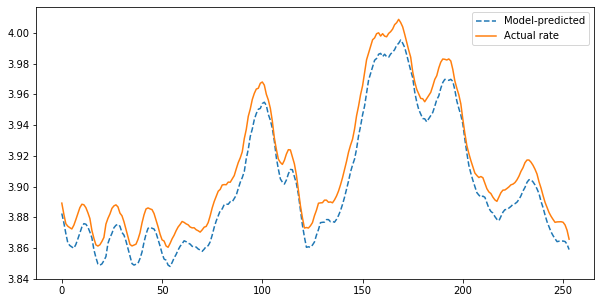

Mean squared error: 0.000176
Root Mean squared error: 0.013283
Mean absolute percentage error: 0.003239


In [1055]:
y_pred3  =  model.predict(X_test)
plt.plot(np.exp(y_pred3),'--',label='Model-predicted')
plt.plot(np.exp(y_test),label='Actual rate')
plt.legend()
plt.show()

mse_fnn3 = MSE(np.exp(y_test), np.exp(y_pred3))
rmse_fnn3 = np.sqrt(mse_fnn3)
mape_fnn3 = MAPE(np.exp(y_test), np.exp(y_pred3))
print('Mean squared error: {0:3f}'.format(mse_fnn3))
print('Root Mean squared error: {0:3f}'.format(rmse_fnn3))
print('Mean absolute percentage error: {0:3f}'.format(mape_fnn3))

## 4. LSTM- Recurrent Neural Network (LSTM-RNN)

In [1056]:
df_train = df.loc[:"2018"]
df_test = df.loc["2019":]
rm_train = pd.Series.rolling(df_train['SGD_USD'],window=7,center=False).mean()
rm_train.dropna(inplace=True)

rm_test = pd.Series.rolling(df_test['SGD_USD'],window=7,center=False).mean()
rm_test.dropna(inplace=True)

rm_train = pd.DataFrame(rm_train)
rm_train['SGD_USD_Target'] = rm_train['SGD_USD'].shift(-1)
rm_train.dropna(inplace=True)
rm_test = pd.DataFrame(rm_test)
rm_test['SGD_USD_Target'] = rm_test['SGD_USD'].shift(-1)
rm_test.dropna(inplace=True)

train = rm_train.values
test = rm_test.values
#print(train)
X_train,y_train = train[:, :-1], train[:, -1]
X_test,y_test = test[:, :-1], test[:, -1]

In [1057]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [1058]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(10, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(10,input_shape=(1, X_train.shape[1]), activation='relu'))

model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
4949/4949 [==============================] - 6s 1ms/step - loss: 0.0437
Epoch 2/200
4949/4949 [==============================] - 5s 1ms/step - loss: 2.7053e-05
Epoch 3/200
4949/4949 [==============================] - 5s 1ms/step - loss: 2.2367e-05A: 0s - loss:
Epoch 4/200
4949/4949 [==============================] - 5s 1ms/step - loss: 3.0534e-05
Epoch 5/200
4949/4949 [==============================] - 5s 1ms/step - loss: 3.2296e-05A: 3s - loss - ET - ETA: 0s - loss: 3.380
Epoch 6/200
4949/4949 [==============================] - 5s 1ms/step - loss: 3.3589e-05A: 0s - l
Epoch 7/200
4949/4949 [==============================] - 5s 1ms/step - loss: 3.3380e-05
Epoch 8/200
4949/4949 [==============================] - ETA: 0s - loss: 3.6332e-0 - 5s 1ms/step - loss: 3.6237e-05
Epoch 9/200
4949/4949 [==============================] - 5s 1ms/step - loss: 3.9523e-05
Epoch 10/200
4949/4949 [==============================] - 5s 1ms/step - loss: 4.3211e-05
Epoch 11/200
4949/4949 [========

In [1059]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

print("The MSE on the Train set is:\t{:0.3f}".format(MSE(np.exp(y_train), np.exp(y_train_pred_lstm))))
print("The MSE on the Test set is:\t{:0.3f}".format(MSE(np.exp(y_test), np.exp(y_pred_test_lstm))))

mse_train = MSE(np.exp(y_train), np.exp(y_train_pred_lstm))
mse_test = MSE(np.exp(y_test), np.exp(y_pred_test_lstm))
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
mape_train = MAPE(np.exp(y_train), np.exp(y_train_pred_lstm))
mape_test = MAPE(np.exp(y_test), np.exp(y_pred_test_lstm))
print('Mean squared error Train: {0:3f}, Test: {0:3f}'.format(mse_train, mse_test))
print('Root Mean squared error Train: {0:3f}, Test: {0:3f}'.format(rmse_train, rmse_test))
print('Mean absolute percentage error Train: {0:3f}, Test: {0:3f}'.format(mape_train, mape_test))

The MSE on the Train set is:	0.646
The MSE on the Test set is:	0.001
Mean squared error Train: 0.646266, Test: 0.646266
Root Mean squared error Train: 0.803907, Test: 0.803907
Mean absolute percentage error Train: 0.112263, Test: 0.112263


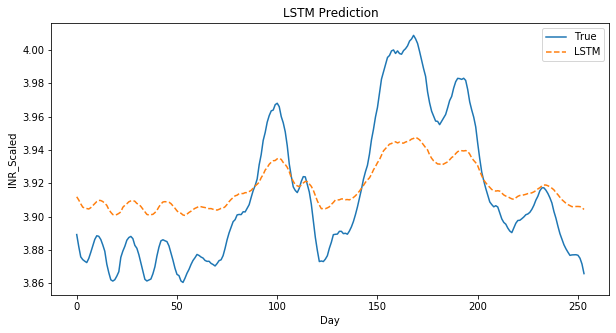

In [1060]:
plt.plot(np.exp(y_test), label='True')
plt.plot(np.exp(y_pred_test_lstm),'--',label='LSTM')
plt.title("LSTM Prediction")
plt.xlabel('Day')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

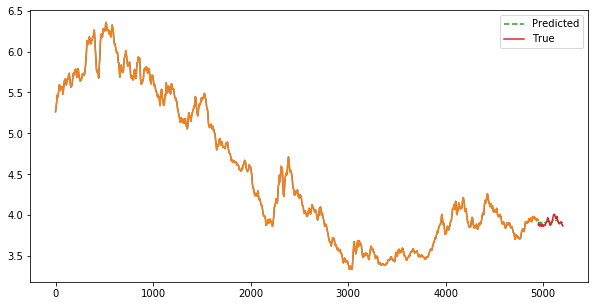

0.0008435950816999244

In [1063]:
plt.plot(np.exp(train))
plt.plot(range(len(rm_train) , len(rm_test)+len(rm_train)),np.exp(y_pred_test_lstm),'--',label='Predicted')
plt.plot(range(len(rm_train) , len(rm_test)+len(rm_train)),np.exp(y_test),label='True')
plt.legend()
plt.show()
MSE(np.exp(y_test),np.exp(y_pred_test_lstm))

In [1064]:
compare=pd.DataFrame({'MSE':[mse_arima, mse_xgboost, mse_fnn, mse_fnn2, mse_fnn3, mse_test],
                      'RMSE':[rmse_arima, rmse_xgboost, rmse_fnn2, rmse_fnn2, rmse_fnn3, rmse_test],
                      'MAPE':[mape_arima, mape_xgboost, mape_fnn3, mape_fnn2, mape_fnn3, mape_test]})
Algorithms=['ARIMA','XGBoost', 'FNN 1 hidden layer', 'FNN 2 hidden layer', 'FNN 4 hidden layer', 'LSTM RNN']
compare['Algorithms']=Algorithms
compare=compare.set_index('Algorithms')
compare

,MSE,RMSE,MAPE
Algorithms,,,
ARIMA,0.000012,0.003515,0.000449
XGBoost,0.000020,0.004478,0.000889
FNN 1 hidden layer,0.000021,0.007939,0.003239
FNN 2 hidden layer,0.000063,0.007939,0.001781
FNN 4 hidden layer,0.000176,0.013283,0.003239
LSTM RNN,0.000844,0.029045,0.006460


# Conclusion for Univariate forecasting
ARIMA performs better than the rest wrt MSE

## 1. Vector Auto Regression (VAR)

In a VAR model, each variable is a linear function of the past values of itself and the past values of all the other variables.

In [1065]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [1066]:
rm_train = pd.Series.rolling(df_train[['SGD_USD', 'CNY_USD']],window=7,center=False).mean()
#rm_diff_train=df_train['SGD_USD']-rm_train
rm_train.dropna(inplace=True)

rm_test = pd.Series.rolling(df_test[['SGD_USD', 'CNY_USD']],window=7,center=False).mean()
#rm_diff_test=df_test['SGD_USD']-rm_test
rm_test.dropna(inplace=True)

In [1067]:
#missing value treatment
cols = df[['SGD_USD', 'CNY_USD']].columns

#checking stationarity
#from statsmodels.tsa.vector_ar.vecm import coint_johansen
#Perform the Johansen cointegration test for determining the cointegration rank of a VECM.
#coint_johansen(df[['SGD_USD', 'CNY_USD']],-1,1).eig

In [1068]:
model = VAR(endog=rm_train)
model_fit = model.fit()

C:\Users\meetn\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


In [1069]:
# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(rm_test))

C:\Users\meetn\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [1070]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,2):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', np.sqrt(MSE(pred[i], rm_test[i])))

rmse value for SGD_USD is :  0.01851742899502728
rmse value for CNY_USD is :  0.22114139304540545


In [1071]:
#make final predictions
model = VAR(endog=df[['SGD_USD', 'CNY_USD']])
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

[[1.34461213 6.9605582 ]]


C:\Users\meetn\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\Users\meetn\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [1072]:
mse_multivar = MSE(rm_test['SGD_USD'],pred['SGD_USD'])
rmse_multivar = np.sqrt(mse_multivar)
mape_multivar = MAPE(rm_test['SGD_USD'],pred['SGD_USD'])
print('Mean squared error: {0:3f}'.format(mse_multivar))
print('Root Mean squared error: {0:3f}'.format(rmse_multivar))
print('Mean absolute percentage error: {0:3f}'.format(mape_multivar))

Mean squared error: 0.000343
Root Mean squared error: 0.018517
Mean absolute percentage error: 0.011466


## 2. Multivariate Time Series Forecasting with LSTM

In [1073]:
df_train = df.loc[:"2018"]
df_test = df.loc["2019":]
rm_train = pd.Series.rolling(df_train[['SGD_USD', 'CNY_USD']],window=7,center=False).mean()
rm_train.dropna(inplace=True)

rm_test = pd.Series.rolling(df_test[['SGD_USD', 'CNY_USD']],window=7,center=False).mean()
rm_test.dropna(inplace=True)

In [1074]:
rm_train['SGD_USD_Target'] = rm_train['SGD_USD'].shift(-1)
rm_train.dropna(inplace=True)
rm_test['SGD_USD_Target'] = rm_test['SGD_USD'].shift(-1)
rm_test.dropna(inplace=True)

In [1075]:
train = rm_train.values
test = rm_test.values
#print(train)
X_train,y_train = train[:, :-1], train[:, -1]
X_test,y_test = test[:, :-1], test[:, -1]

#Split the training set into 2 set - one for training and one for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [1076]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(3959, 1, 2) (3959,) (990, 1, 2) (990,) (254, 1, 2) (254,)


Train on 3959 samples, validate on 990 samples
Epoch 1/50
 - 0s - loss: 0.8085 - val_loss: 0.0206
Epoch 2/50
 - 0s - loss: 0.0056 - val_loss: 0.0043
Epoch 3/50
 - 0s - loss: 0.0040 - val_loss: 0.0042
Epoch 4/50
 - 0s - loss: 0.0039 - val_loss: 0.0040
Epoch 5/50
 - 0s - loss: 0.0037 - val_loss: 0.0039
Epoch 6/50
 - 0s - loss: 0.0036 - val_loss: 0.0037
Epoch 7/50
 - 0s - loss: 0.0034 - val_loss: 0.0036
Epoch 8/50
 - 0s - loss: 0.0033 - val_loss: 0.0034
Epoch 9/50
 - 0s - loss: 0.0031 - val_loss: 0.0033
Epoch 10/50
 - 0s - loss: 0.0030 - val_loss: 0.0031
Epoch 11/50
 - 0s - loss: 0.0028 - val_loss: 0.0030
Epoch 12/50
 - 0s - loss: 0.0027 - val_loss: 0.0029
Epoch 13/50
 - 0s - loss: 0.0026 - val_loss: 0.0027
Epoch 14/50
 - 0s - loss: 0.0025 - val_loss: 0.0026
Epoch 15/50
 - 0s - loss: 0.0024 - val_loss: 0.0026
Epoch 16/50
 - 0s - loss: 0.0023 - val_loss: 0.0025
Epoch 17/50
 - 0s - loss: 0.0022 - val_loss: 0.0024
Epoch 18/50
 - 0s - loss: 0.0022 - val_loss: 0.0023
Epoch 19/50
 - 0s - loss: 

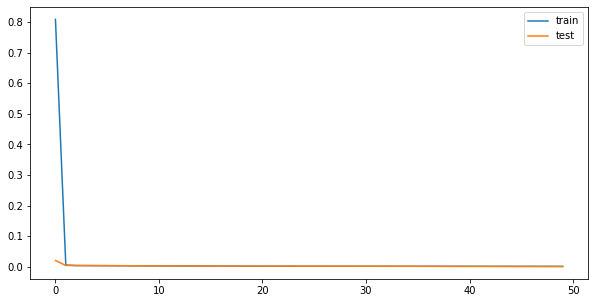

In [1077]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_val, y_val), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [1078]:
# make a prediction
yhat = model.predict(X_test)
test_X = X_test.reshape((X_test.shape[0], X_test.shape[2]))
test_y = y_test.reshape((len(y_test), 1))
mse_multivar_lstm = MSE(test_y,yhat)
rmse_multivar_lstm = np.sqrt(mse_multivar_lstm)
mape_multivar_lstm = MAPE(test_y, yhat)
print('Mean squared error: {0:3f}'.format(mse_multivar_lstm))
print('Root Mean squared error: {0:3f}'.format(rmse_multivar_lstm))
print('Mean absolute percentage error: {0:3f}'.format(mape_multivar_lstm))

Mean squared error: 0.001131
Root Mean squared error: 0.033629
Mean absolute percentage error: 0.021589


In [1079]:
compare=pd.DataFrame({'MSE':[mse_multivar, mse_multivar_lstm],
                      'RMSE':[rmse_multivar, rmse_multivar_lstm],
                      'MAPE':[mape_multivar, mape_multivar_lstm]})
Multivariate_Algos =['Vector Auto Regression (VAR)','Multivariate Time Series Forecasting with LSTM']
compare['Multivariate_Algos']=Multivariate_Algos
compare=compare.set_index('Multivariate_Algos')
compare

,MSE,RMSE,MAPE
Multivariate_Algos,,,
Vector Auto Regression (VAR),0.000343,0.018517,0.011466
Multivariate Time Series Forecasting with LSTM,0.001131,0.033629,0.021589


# Conclusion for Multivariate forecasting

Considering MSE, Vector Auto Regression (VAR) produces better results in multivariate forecasting than LSTM